In [1]:
import glob as g
import ujson
import os
import os.path as op
import re
import subprocess as sp
from subprocess import CalledProcessError
import time
import ocrolib
import copy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os.path
sys.path.append(os.path.abspath('../catconv'))
import catconv.stabi as sb
import catconv.operations as co

In [20]:
with open('/home/jakob/data/ST.json', 'rb') as ST:
    catalog = ujson.load(ST)

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np

def vertices(line):
    x0, y0 ,x1,y1 = line
    return {'verts': 
            [(x0, y0),
            (x1, y0),
            (x1, y1), 
            (x0, y1),
            (x0, y0)],
            'codes':
            [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY]}

def plot_lines(verts):
    return [v[0] for v in verts], [v[1] for v in verts]



In [5]:
def page_filter(page):
    return True
def all_filter(arg):
    return True
def line_filter(line):
    x0, y0 ,x1,y1 = line['position']
    if y0 < 450 and x0 > 400:
        return True
    else:
        return False


In [6]:
def line_image(page, line):
    return op.join(page_dir(page['path']), line['name'] + '.bin.png')

In [7]:
def dump_images_to_html_string(images):
    img  = """<p>{}<img src=\"{}\"/></p>"""
    html = """<html><body>{}</body></html>"""
    elements = []
    for image in images:
        elements.append(img.format(image,op.abspath(image)))
        
    return html.format('\n'.join(elements))

In [52]:
def plot_catalog(catalog,page_filter, line_filter):
    card_size_verts = vertices([0,0,1008,608])
    images = []
    for page in filter(page_filter, catalog['pages']):
        for idx, line in enumerate(page['lines']):
            if line_filter(line):
                color = 'green'
                if idx == 0:
                    color = 'black'
            else:
                color = 'red'
            
            plt.plot(*plot_lines(vertices(line['position'])['verts']), color=color)
    #         images.append(line_image(page,line))

    plt.xlim([0,1008])
    plt.ylim([0,608])
    plt.title('Gefilterte Textzeilen')
    plt.ylabel('Position in px')
    plt.xlabel('Position in px')
    plt.savefig('plots/filtered_num.png')
    html = dump_images_to_html_string(images[:200:2])
    with open('filtered_lines.html', 'w') as out:
        out.write(html)
   

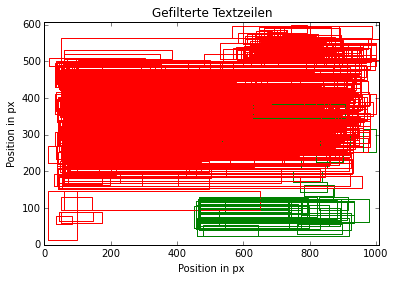

In [53]:
plot_catalog(catalog, page_filter, line_filter)

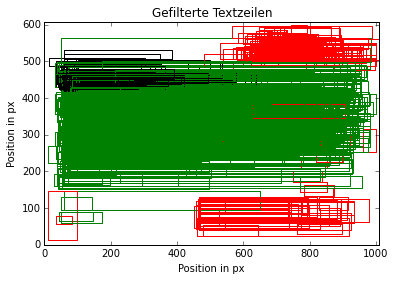

In [54]:
def index_line_filter(line):
    x0, y0 ,x1,y1 = line['position']
    if x0 < 400 and x1 > 100:
        return True
    else:
        return False

plot_catalog(catalog, page_filter,index_line_filter)

In [8]:
CAT_NAME = 'SD'
CAT_CONV = 'SD_png'
CAT_PATH = '../SD_png/'
DB_PATH  = 'data/convert.json'
N = 10
# Example page
page1 = {'path': '../SD_png/SD012/00000111'}
model = '../htwmusik-models/catalog2-gt-model.model-00101000.pyrnn.gz'

In [234]:

pre_job = lambda page: predict(op.join(change_path(page['path']),'*.bin.png'), model)
selected_pages = filter(seg_is_complete, catalog['pages'])
selected_pages = filter(seg_is_complete, selected_pages)
has_no_text = lambda page: op.isdir(sb.page_dir(page['path'])) and not all(map(op.isfile, text_files(page).values()))
selected_pages = filter(has_no_text, selected_pages)
print page1
print has_no_text(page1)
print len(selected_pages)
pre_jobs       = map(pre_job, selected_pages)
pre_job(selected_pages[1])
# execute_job(pre_job(selected_pages[1]))

{'path': '../SD_png/SD012/00000111', 'lines': [{'position': [86L, 528L, 874L, 557L], 'name': '010001', 'text': ''}, {'position': [47L, 478L, 226L, 501L], 'name': '010002', 'text': 'Holli er Heinz:\n'}, {'position': [47L, 439L, 913L, 466L], 'name': '010003', 'text': 'Schneewittchen : Oper in 5 Szenen, einem Prolog und einem Epilog nach\n'}, {'position': [46L, 405L, 913L, 433L], 'name': '010004', 'text': 'Robert Walser / Heinz Holliger. - Grifelfing : ECM-Records-Verlag;\n'}, {'position': [46L, 369L, 915L, 398L], 'name': '010005', 'text': 'Hamburg : Universal Music, Vertrieb, [2001]. - 2 Compact Discs in Schuber\n'}, {'position': [47L, 335L, 714L, 362L], 'name': '010006', 'text': '+ Beih. (mit dt, engl, franz Libretto). - (ECM new series)\n'}, {'position': [47L, 301L, 913L, 328L], 'name': '010007', 'text': ''}, {'position': [46L, 266L, 913L, 294L], 'name': '010008', 'text': ''}, {'position': [45L, 233L, 914L, 260L], 'name': '010009', 'text': ''}, {'position': [46L, 205L, 106L, 225L], 'na

['ocropus-rpred',
 '-Q',
 '1',
 '-m',
 '../htwmusik-models/catalog2-gt-model.model-00101000.pyrnn.gz',
 '../SD_png/SD012/00000321/*.bin.png']

In [13]:
page1

{'path': '../SD_png/SD012/00000111'}

In [14]:
# pre_execution = map(execute_job,pre_jobs)

In [15]:
selected_pages

NameError: name 'selected_pages' is not defined

In [16]:
def text_files(page):
    if 'lines' in page:
        return {line['name']: op.join(page['path'],line['name'] + '.txt') for line in page['lines']}
    else:
        return {}

In [17]:
page1

{'path': '../SD_png/SD012/00000111'}

In [ ]:
pre_excecution = map(execute_job,pre_jobs)

In [18]:
pre_job = lambda page: predict(page['path'], model)
pre_jobs       = map(pre_job, pages)
pre_excecution = map(execute_job,pre_jobs)

NameError: name 'pages' is not defined

In [230]:
execution_stats(pre_excecution)

(8.1798688471317291, 's per job')
(0, 'not completed')


In [248]:
sb.load_box_positions(page1)
sb.read_text(page1)
page1

{'lines': [{'name': '010001', 'position': [86L, 528L, 874L, 557L], 'text': ''},
  {'name': '010002',
   'position': [47L, 478L, 226L, 501L],
   'text': 'Holli er Heinz:\n'},
  {'name': '010003',
   'position': [47L, 439L, 913L, 466L],
   'text': 'Schneewittchen : Oper in 5 Szenen, einem Prolog und einem Epilog nach\n'},
  {'name': '010004',
   'position': [46L, 405L, 913L, 433L],
   'text': 'Robert Walser / Heinz Holliger. - Grifelfing : ECM-Records-Verlag;\n'},
  {'name': '010005',
   'position': [46L, 369L, 915L, 398L],
   'text': 'Hamburg : Universal Music, Vertrieb, [2001]. - 2 Compact Discs in Schuber\n'},
  {'name': '010006',
   'position': [47L, 335L, 714L, 362L],
   'text': '+ Beih. (mit dt, engl, franz Libretto). - (ECM new series)\n'},
  {'name': '010007', 'position': [47L, 301L, 913L, 328L], 'text': ''},
  {'name': '010008', 'position': [46L, 266L, 913L, 294L], 'text': ''},
  {'name': '010009', 'position': [45L, 233L, 914L, 260L], 'text': ''},
  {'name': '01000a', 'position'

In [15]:
def pretty(catalog):
    print ujson.encode(catalog,ensure_ascii=False,indent=2, escape_forward_slashes=False)

In [15]:

# batch1 = {'batch': '001'}
catalog = sb.load_catalog('/home/jakob/data/ST',selection={}, text_box=False, text=False)
catalog

{'name': 'ST',
 'pages': [{'path': '/home/jakob/data/ST/ST001/00000510.png'},
  {'path': '/home/jakob/data/ST/ST003/00000267.png'},
  {'path': '/home/jakob/data/ST/ST005/00000070.png'},
  {'path': '/home/jakob/data/ST/ST008/00000183.png'},
  {'path': '/home/jakob/data/ST/ST011/00000230.png'},
  {'path': '/home/jakob/data/ST/ST014/00000656.png'},
  {'path': '/home/jakob/data/ST/ST016/00000618.png'},
  {'path': '/home/jakob/data/ST/ST018/00000683.png'},
  {'path': '/home/jakob/data/ST/ST021/00000273.png'},
  {'path': '/home/jakob/data/ST/ST023/00000940.png'},
  {'path': '/home/jakob/data/ST/ST025/00000028.png'},
  {'path': '/home/jakob/data/ST/ST030/00000128.png'},
  {'path': '/home/jakob/data/ST/ST033/00000572.png'},
  {'path': '/home/jakob/data/ST/ST035/00000411.png'},
  {'path': '/home/jakob/data/ST/ST038/00000016.png'},
  {'path': '/home/jakob/data/ST/ST040/00000433.png'},
  {'path': '/home/jakob/data/ST/ST043/00000653.png'},
  {'path': '/home/jakob/data/ST/ST045/00000896.png'},
  {'

In [25]:
int("01000a"[2:],16)

10

In [41]:
pages = catalog['pages']
lines = sorted(pages[0]['lines'], key=lambda line: line['name'] )
map(lambda line: line['text'], lines)

['Abxraham, Paul\n',
 'DMS 219 788\n',
 'Die te Yon Bawaii. Operette in 5 Akten von\n',
 'Alfred x~nwald, Bmmexrich Fldea w- Bada [d.i.\n',
 'Prit L~hner]. Muaik von Paul Abraham. GroBea\n',
 'Potpouxri von Nico Doatal. [Fxr Ge aang u. Klavior.]\n',
 'aael Doremi (1952J. 15 S. 4\n']

In [259]:
texted = [page for page in catalog['pages'] if op.basename(sb.change_path(page['path'])) == '00000111']
print has_no_text(texted[0])
print texted[0]
sb.read_text(texted[0])
texted

True
{'path': '../SD_png/SD012/00000111.png', 'lines': [{'position': [86L, 528L, 874L, 557L], 'name': '010001', 'text': ''}, {'position': [47L, 478L, 226L, 501L], 'name': '010002', 'text': 'Holli er Heinz:\n'}, {'position': [47L, 439L, 913L, 466L], 'name': '010003', 'text': 'Schneewittchen : Oper in 5 Szenen, einem Prolog und einem Epilog nach\n'}, {'position': [46L, 405L, 913L, 433L], 'name': '010004', 'text': 'Robert Walser / Heinz Holliger. - Grifelfing : ECM-Records-Verlag;\n'}, {'position': [46L, 369L, 915L, 398L], 'name': '010005', 'text': 'Hamburg : Universal Music, Vertrieb, [2001]. - 2 Compact Discs in Schuber\n'}, {'position': [47L, 335L, 714L, 362L], 'name': '010006', 'text': '+ Beih. (mit dt, engl, franz Libretto). - (ECM new series)\n'}, {'position': [47L, 301L, 913L, 328L], 'name': '010007', 'text': ''}, {'position': [46L, 266L, 913L, 294L], 'name': '010008', 'text': ''}, {'position': [45L, 233L, 914L, 260L], 'name': '010009', 'text': ''}, {'position': [46L, 205L, 106L, 2

[{'lines': [{'name': '010001',
    'position': [86L, 528L, 874L, 557L],
    'text': ''},
   {'name': '010002',
    'position': [47L, 478L, 226L, 501L],
    'text': 'Holli er Heinz:\n'},
   {'name': '010003',
    'position': [47L, 439L, 913L, 466L],
    'text': 'Schneewittchen : Oper in 5 Szenen, einem Prolog und einem Epilog nach\n'},
   {'name': '010004',
    'position': [46L, 405L, 913L, 433L],
    'text': 'Robert Walser / Heinz Holliger. - Grifelfing : ECM-Records-Verlag;\n'},
   {'name': '010005',
    'position': [46L, 369L, 915L, 398L],
    'text': 'Hamburg : Universal Music, Vertrieb, [2001]. - 2 Compact Discs in Schuber\n'},
   {'name': '010006',
    'position': [47L, 335L, 714L, 362L],
    'text': '+ Beih. (mit dt, engl, franz Libretto). - (ECM new series)\n'},
   {'name': '010007', 'position': [47L, 301L, 913L, 328L], 'text': ''},
   {'name': '010008', 'position': [46L, 266L, 913L, 294L], 'text': ''},
   {'name': '010009', 'position': [45L, 233L, 914L, 260L], 'text': ''},
   {

In [ ]:
relPagePaths = {'rel_path': '../', 'remove_type': True}
change_paths(catalog, relPagePaths)

In [11]:
change_path('../SD_png/SD012/00000282.pseg.png',rel_path='../',remove_type=True)

'SD_png/00000282.pseg'

In [53]:
sorted(catalog['pages'])

[{'path': '/home/jakob/data/SB/SB001/00000510.png'},
 {'path': '/home/jakob/data/SB/SB003/00000267.png'},
 {'path': '/home/jakob/data/SB/SB005/00000070.png'},
 {'path': '/home/jakob/data/SB/SB008/00000183.png'},
 {'path': '/home/jakob/data/SB/SB011/00000230.png'},
 {'path': '/home/jakob/data/SB/SB014/00000656.png'},
 {'path': '/home/jakob/data/SB/SB016/00000618.png'},
 {'path': '/home/jakob/data/SB/SB018/00000683.png'},
 {'path': '/home/jakob/data/SB/SB021/00000273.png'},
 {'path': '/home/jakob/data/SB/SB023/00000940.png'},
 {'path': '/home/jakob/data/SB/SB025/00000028.png'},
 {'path': '/home/jakob/data/SB/SB030/00000128.png'},
 {'path': '/home/jakob/data/SB/SB033/00000572.png'},
 {'path': '/home/jakob/data/SB/SB035/00000411.png'},
 {'path': '/home/jakob/data/SB/SB038/00000016.png'},
 {'path': '/home/jakob/data/SB/SB040/00000433.png'},
 {'path': '/home/jakob/data/SB/SB043/00000653.png'},
 {'path': '/home/jakob/data/SB/SB045/00000896.png'},
 {'path': '/home/jakob/data/SB/SB047/00000530.

In [28]:
import copy

export_conv = {'rel_path': '/home/jakob/data/SB'}
print catalog['pages'][0]['path']
c_catalog = copy.deepcopy(catalog)
limit = 2
with open('data/SB.json','wb') as export:
    for page in c_catalog['pages']:
        page['path'] = sb.change_path(page['path'],**export_conv)
    c_catalog['pages'] = c_catalog['pages'][:limit]
    export.write(ujson.dumps(c_catalog, ensure_ascii=False,indent=2, escape_forward_slashes=False))
print c_catalog['pages'][0]['path']

/home/jakob/data/SB/SB001/00000510.png
SB001/00000510


In [ ]:
ujson.dump

In [13]:
!cat data/SB.json

{
  "path":"/home/jakob/data/SB",
  "name":"SB",
  "pages":[
    {
      "path":"SB001/00000510",
      "lines":[
        {
          "position":[
            56,
            450,
            292,
            477
          ],
          "name":"010001",
          "text":"Abxraham, Paul\n"
        },
        {
          "position":[
            622,
            520,
            822,
            545
          ],
          "name":"010002",
          "text":"DMS 219 788\n"
        },
        {
          "position":[
            57,
            376,
            877,
            407
          ],
          "name":"010003",
          "text":"Die te Yon Bawaii. Operette in 5 Akten von\n"
        },
        {
          "position":[
            56,
            342,
            888,
            381
          ],
          "name":"010004",
          "text":"Alfred x~nwald, Bmmexrich Fldea w- Bada [d.i.\n"
        },
        {
          "position":[
            57,
            311,
            874,
  

In [158]:
print sb.change_path(catalog['pages'][1]['path'],**export_conv)
print op.join(catalog['path'],catalog['pages'][1]['path'])

../catalog-ocr-test/SD012/00000321
../SD_png/SD012/00000321


In [232]:
any(map(op.isfile, text_files(page1).values()))

True

In [64]:
import itertools as it
lines = [page['lines'] for page in catalog['pages']]
# text = [line['text'] for line in lines]
all_lines = it.chain(*lines)
text = [line['text'] for line in all_lines]
